### _Imports_

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model  import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pylab as plt

import functions as fn # importing pre-defined functions from .py file (inside notebooks folder)

### Upload diamonds train data from csv

In [2]:
diamonds_train = pd.read_csv('../data/diamonds_train.csv')
#diamonds_train.head()

**Remark**: For the diamonds dataset, we have conducted an exploratory data analysis (EDA) in advance. Find references [here](https://github.com/Kristinawk/EDA_Diamonds).  
  
This dataset doesn't have nulls, therefore we can proceed directly with encoding.

## 1. Features selection and engineering

During EDA we saw that some diamonds have ceros in size parameters x, y and z. It would be better to take these rows out for machine learning.

In [3]:
diamonds_train.describe()

,price,carat,depth,table,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.797706,61.752841,57.446133,5.729392,5.732819,3.537154
std,3992.416147,0.475544,1.431725,2.233535,1.124453,1.146650,0.697062
min,326.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000


In [4]:
len(diamonds_train.query('x == 0 or y == 0 or z == 0'))

16

In total, there are 16 rows with this issue. Lets drop these values.

In [5]:
diamonds_train.drop(diamonds_train.query('x == 0 or y == 0 or z == 0').index, inplace=True)

In [6]:
diamonds_train.describe()

,price,carat,depth,table,x,y,z
count,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000
mean,3926.535448,0.797425,61.753013,57.445543,5.729616,5.732897,3.538553
std,3990.024501,0.475257,1.431306,2.233055,1.122384,1.145002,0.693639
min,326.000000,0.200000,43.000000,43.000000,3.770000,3.720000,1.070000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2396.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,5329.500000,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000


Additionally we can do outliers analysis for these variables.

In [7]:
for col in ['x', 'y', 'z']:
    q1 = diamonds_train[col].quantile(0.25)
    q3 = diamonds_train[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    upper_array = np.array(diamonds_train[col] >= upper)
    lower = q1 - 1.5 * iqr
    lower_array = np.array(diamonds_train[col] <= lower)
    print(col, "Upper bound:", upper, "Lower bound:", lower)
    print(col, "Upper outliers", upper_array.sum(), "Lower outliers", lower_array.sum(), '\n')

x Upper bound: 9.285 Lower bound: 1.9649999999999999
x Upper outliers 18 Lower outliers 0 

y Upper bound: 9.27 Lower bound: 1.9899999999999993
y Upper outliers 18 Lower outliers 0 

z Upper bound: 5.734999999999999 Lower bound: 1.2150000000000003
z Upper outliers 19 Lower outliers 1 



In [8]:
len(diamonds_train.query('x > 9.28 or y > 9.27 or z > 5.73'))

27

Lets take out also these 27 rows.

In [9]:
diamonds_train.drop(diamonds_train.query('x > 9.28 or y > 9.27 or z > 5.73').index, inplace=True)

### New features

In [10]:
#diamonds_train['volume'] = diamonds_train['x'] * diamonds_train['y'] * diamonds_train['z']

In [11]:
#diamonds_train['tot_depth_percentage'] = diamonds_train['z'] * diamonds_train['x']

In [12]:
diamonds_train['fletin'] = diamonds_train['z'] - ((diamonds_train['depth']/100) * diamonds_train['z'])

In [13]:
diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity,fletin
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,1.59800
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,1.01750
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,1.25925
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,1.08600
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,1.56025


In [14]:
cat_var_lst = ["city", "cut", "color", "clarity"]
non_cat_var = diamonds_train.drop(cat_var_lst, axis=1)

In [15]:
non_cat_var.corr()

,price,carat,depth,table,x,y,z,fletin
price,1.000000,0.923274,-0.015823,0.129495,0.887457,0.889075,0.881896,0.884942
carat,0.923274,1.000000,0.025153,0.183216,0.978966,0.978073,0.977481,0.970550
depth,-0.015823,0.025153,1.000000,-0.292831,-0.027122,-0.030341,0.093918,-0.107227
table,0.129495,0.183216,-0.292831,1.000000,0.196822,0.190767,0.157162,0.212351
x,0.887457,0.978966,-0.027122,0.196822,1.000000,0.998663,0.991194,0.995301
y,0.889075,0.978073,-0.030341,0.190767,0.998663,1.000000,0.990845,0.995679
z,0.881896,0.977481,0.093918,0.157162,0.991194,0.990845,1.000000,0.979071
fletin,0.884942,0.970550,-0.107227,0.212351,0.995301,0.995679,0.979071,1.000000


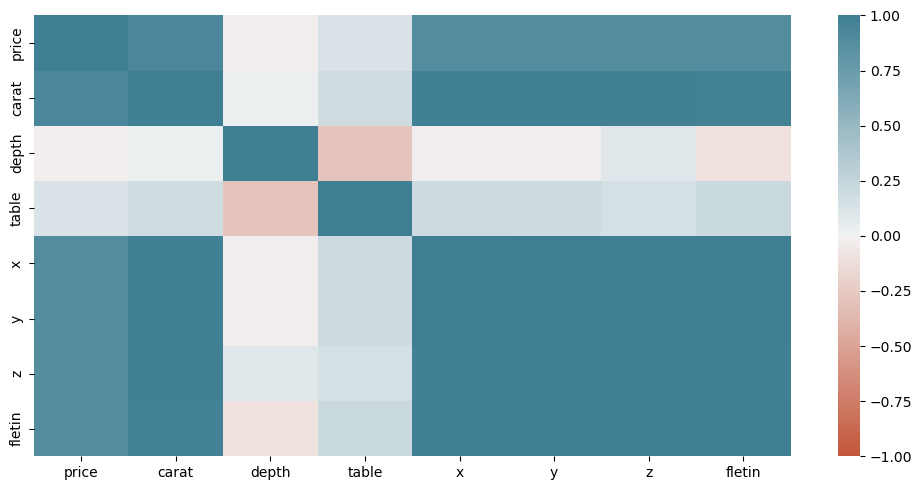

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(non_cat_var.corr(),
                 vmin=-1,
                 vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)
plt.tight_layout()

In [17]:
non_cat_var.describe()

,price,carat,depth,table,x,y,z,fletin
count,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000
mean,3919.081312,0.795810,61.752643,57.444776,5.727184,5.729259,3.536927,1.351853
std,3979.978307,0.471078,1.429715,2.232493,1.118725,1.110596,0.690877,0.264537
min,326.000000,0.200000,43.000000,43.000000,3.770000,3.720000,1.070000,0.421580
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,1.110470
50%,2394.000000,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,1.338920
75%,5321.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,1.549800
max,18823.000000,3.050000,79.000000,95.000000,9.260000,9.250000,5.730000,2.348400


In [18]:
diamonds_train.drop(['x', 'y', 'z', 'depth'], axis=1, inplace=True)

In [19]:
cat_var_lst = ["city", "cut", "color", "clarity"]
non_cat_var = diamonds_train.drop(cat_var_lst, axis=1)

In [20]:
non_cat_var.corr()

,price,carat,table,fletin
price,1.000000,0.923274,0.129495,0.884942
carat,0.923274,1.000000,0.183216,0.970550
table,0.129495,0.183216,1.000000,0.212351
fletin,0.884942,0.970550,0.212351,1.000000


## 2. Encoding

### Categorical variables overview

In [21]:
cat_var_lst = ["city", "cut", "color", "clarity"]
#cat_var_overview = fn.cat_var(diamonds_train, cat_var_lst)
#cat_var_overview

### One hot encoding

In [22]:
baseline_train = fn.one_hot_encod(diamonds_train, cat_var_lst)

In [23]:
#baseline_train.head()

Checking that all features are numeric

In [24]:
#baseline_train.info()

### Save pre-processing to csv

In [25]:
#baseline_train.to_csv('../data/baseline_train.csv', index=False)

## 3. Model selection

In [26]:
y = baseline_train['price'].astype('float64').to_numpy()
X = baseline_train[[col for col in baseline_train.columns if col != 'price']].to_numpy()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
#print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

## 3. e) RandomForestRegressor

In [28]:
model_randomforest = RandomForestRegressor()

fn.cross_val(model_randomforest, X, y)

Cross val. scores: [-647.20461022 -663.49728534 -641.89787344 -650.52241937 -654.15273988] 

Mean of scores: 651.4549856495041 



## 3. g) ExtraTreesRegressor

In [29]:
model_extratrees = ExtraTreesRegressor()

fn.cross_val(model_extratrees, X, y)

Cross val. scores: [-635.27801178 -623.93115232 -615.14555297 -624.97518647 -617.02200383] 

Mean of scores: 623.2703814744864 



**CONCLUSION**: the changes in features in this notebook improve model prediction: from 662 to 657 for RandomForest and from 613 to 612 for ExtraTrees.

### Grid Search: RandomForestRegressor

In [30]:
'''param_grid = {'n_estimators': [100, 200, 300],  # Number of trees in the forest.
              'max_depth': [None, 3, 10],  # Maximum depth of the trees.
              'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split.
              }'''

"param_grid = {'n_estimators': [100, 200, 300],  # Number of trees in the forest.\n              'max_depth': [None, 3, 10],  # Maximum depth of the trees.\n              'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node.\n              'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node.\n              'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split.\n              }"

In [31]:
'''grid_search = GridSearchCV(model_randomforest,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)'''

"grid_search = GridSearchCV(model_randomforest,\n                           param_grid,\n                           cv=5,\n                           verbose=3,\n                           scoring='neg_root_mean_squared_error',\n                           n_jobs=-1)"

In [32]:
#grid_search.fit(X, y)

#print('\n')
#print('Best hyperparameters: ', grid_search.best_params_, '\n')
#print('Best score: ', -grid_search.best_score_, '\n')

### Grid Search: ExtraTreesRegressor

In [33]:
'''param_grid = {'n_estimators': [100],  # Number of trees in the forest.
              'max_depth': [None],  # Maximum depth of the trees.
              'min_samples_split': [6],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [2],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None]  # Number of features to consider when looking for the best split.
              }'''

"param_grid = {'n_estimators': [100],  # Number of trees in the forest.\n              'max_depth': [None],  # Maximum depth of the trees.\n              'min_samples_split': [6],  # Minimum number of samples required to split an internal node.\n              'min_samples_leaf': [2],  # Minimum number of samples required to be at a leaf node.\n              'max_features': [None]  # Number of features to consider when looking for the best split.\n              }"

In [34]:
'''grid_search = GridSearchCV(model_extratrees,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)'''

"grid_search = GridSearchCV(model_extratrees,\n                           param_grid,\n                           cv=5,\n                           verbose=3,\n                           scoring='neg_root_mean_squared_error',\n                           n_jobs=-1)"

In [35]:
#grid_search.fit(X, y)

#print('\n')
#print('Best hyperparameters: ', grid_search.best_params_, '\n')
#print('Best score: ', -grid_search.best_score_, '\n')

### Fit Model

In [36]:
model_extratrees.fit(X_train, y_train)
y_pred = model_extratrees.predict(X_test)

### Visual check

In [37]:
check = pd.DataFrame({'Ground truth': y_test, 'Predictions': y_pred, 'Diff': y_test - y_pred})
check

,Ground truth,Predictions,Diff
0,5344.0,5350.06,-6.06
1,1897.0,1933.06,-36.06
2,631.0,640.50,-9.50
3,2349.0,2607.45,-258.45
4,8889.0,9724.25,-835.25
...,...,...,...
8078,2307.0,2146.78,160.22
8079,4866.0,4098.30,767.70
8080,5385.0,6072.04,-687.04
8081,2416.0,3180.64,-764.64


In [38]:
check.reset_index(inplace=True)

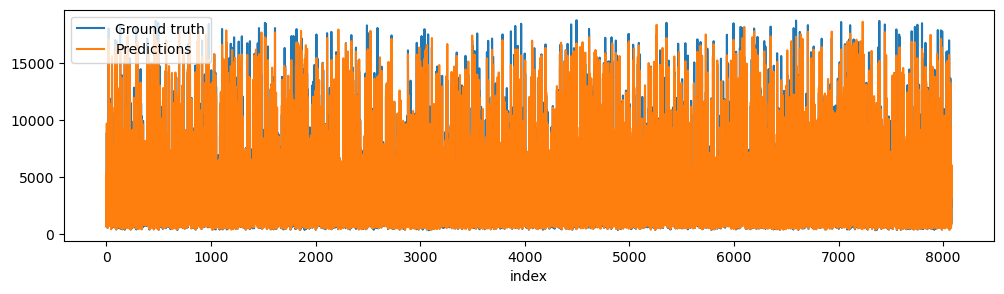

In [39]:
check.plot(x='index', y=['Ground truth', 'Predictions'], kind='line', figsize=(12, 3));

# 4. Predictions

### Upload diamonds test data from csv

In [48]:
diamonds_test = pd.read_csv('../data/diamonds_test.csv')
#diamonds_test.head()

### Features engineering

In [49]:
#diamonds_test['volume'] = diamonds_test['x'] * diamonds_test['y'] * diamonds_test['z']

In [50]:
diamonds_test['fletin'] = diamonds_test['z'] - ((diamonds_test['depth']/100) * diamonds_test['z'])

In [51]:
diamonds_test.drop(['x', 'y', 'z', 'depth'], axis=1, inplace=True)

### One-hot-encoding

In [52]:
baseline_test = fn.one_hot_encod(diamonds_test, cat_var_lst)

In [53]:
baseline_test = baseline_test.drop('id', axis=1)

In [54]:
#baseline_test.head()

### Predict: ExtraTreesRegressor

In [55]:
extratrees_model_pred = model_extratrees.predict(baseline_test)

C:\Users\Kristina\miniconda3\envs\sklearn_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


In [56]:
extratrees_model_pred

array([3051.25, 5441.22, 9500.69, ..., 2815.16, 2072.9 ,  895.95])

### Save

In [57]:
fn.save_pred(diamonds_test, extratrees_model_pred, 'encod01_featu04_vis3_model01')

'file saved succesfully'